In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points available in general, but work is underway to fill in vital details to increase the dataset as much as possible. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,No,Yes,Yes,Yes,0,18689


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

Manufacturer                      object
model                             object
total dry weight                   int64
length                           float64
Cabin exterior width             float64
exterior height                  float64
interior height highest point    float64
Usage Intent- On or Off Road      object
A/C                               object
Roof Rack                         object
Driver Side Window                object
Driver Side Door                  object
Driver Side Door Window           object
Passenger Side Door               object
Passenger Side Door Window        object
Passenger Side Window             object
Spare Tire                        object
Battery Power Supply              object
Cabinets                          object
Refrigerator                      object
Awning                            object
Solar                             object
STOVE                             object
USB Charging                      object
USB Cost        

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

Manufacturer                     0
model                            5
total dry weight                 0
length                           0
Cabin exterior width             0
exterior height                  0
interior height highest point    0
Usage Intent- On or Off Road     0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
Awning                           0
Solar                            0
STOVE                            0
USB Charging                     0
USB Cost                         0
Base price                       0
dtype: int64

In [5]:
#drop columns which contain many empty values that are unlikely to be helpful in calculations
#data.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp'], axis=1)

In [6]:
#83 is the target but it will be removed later to prevent problems later
#data2=data.drop(data.index[[83]])

In [7]:
data

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,No,Yes,Yes,Yes,0,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,XYZ Camping,NaN,850,144.0,93.0,72.0,47.0,On Road/Off Road,Yes,Yes,...,Option,No,No,No,Option,No,No,No,0,9995
92,XYZ Camping,NaN,850,144.0,93.0,72.0,47.0,On Road/Off Road,Yes,Yes,...,Option,No,No,No,Option,No,No,Yes,0,9995
93,XYZ Camping,NaN,850,144.0,93.0,72.0,47.0,On Road/Off Road,Yes,Yes,...,Option,No,No,No,Option,No,Yes,Yes,0,9995
94,XYZ Camping,NaN,850,144.0,93.0,72.0,47.0,On Road/Off Road,Yes,Yes,...,Option,No,No,No,Option,Yes,Yes,Yes,0,9995


In [8]:
data.isna().sum()

Manufacturer                     0
model                            5
total dry weight                 0
length                           0
Cabin exterior width             0
exterior height                  0
interior height highest point    0
Usage Intent- On or Off Road     0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
Awning                           0
Solar                            0
STOVE                            0
USB Charging                     0
USB Cost                         0
Base price                       0
dtype: int64

In [9]:
data.shape

(96, 26)

In [10]:
#data=data.drop(data.index[[78]])

In [11]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [12]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

In [13]:
data.isna().sum()

Manufacturer                     0
model                            5
tdweight                         0
length                           0
Cabin exterior width             0
eheight                          0
interior height highest point    0
Usage Intent- On or Off Road     0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
Awning                           0
Solar                            0
STOVE                            0
USB Charging                     0
USB Cost                         0
price                            0
dtype: int64

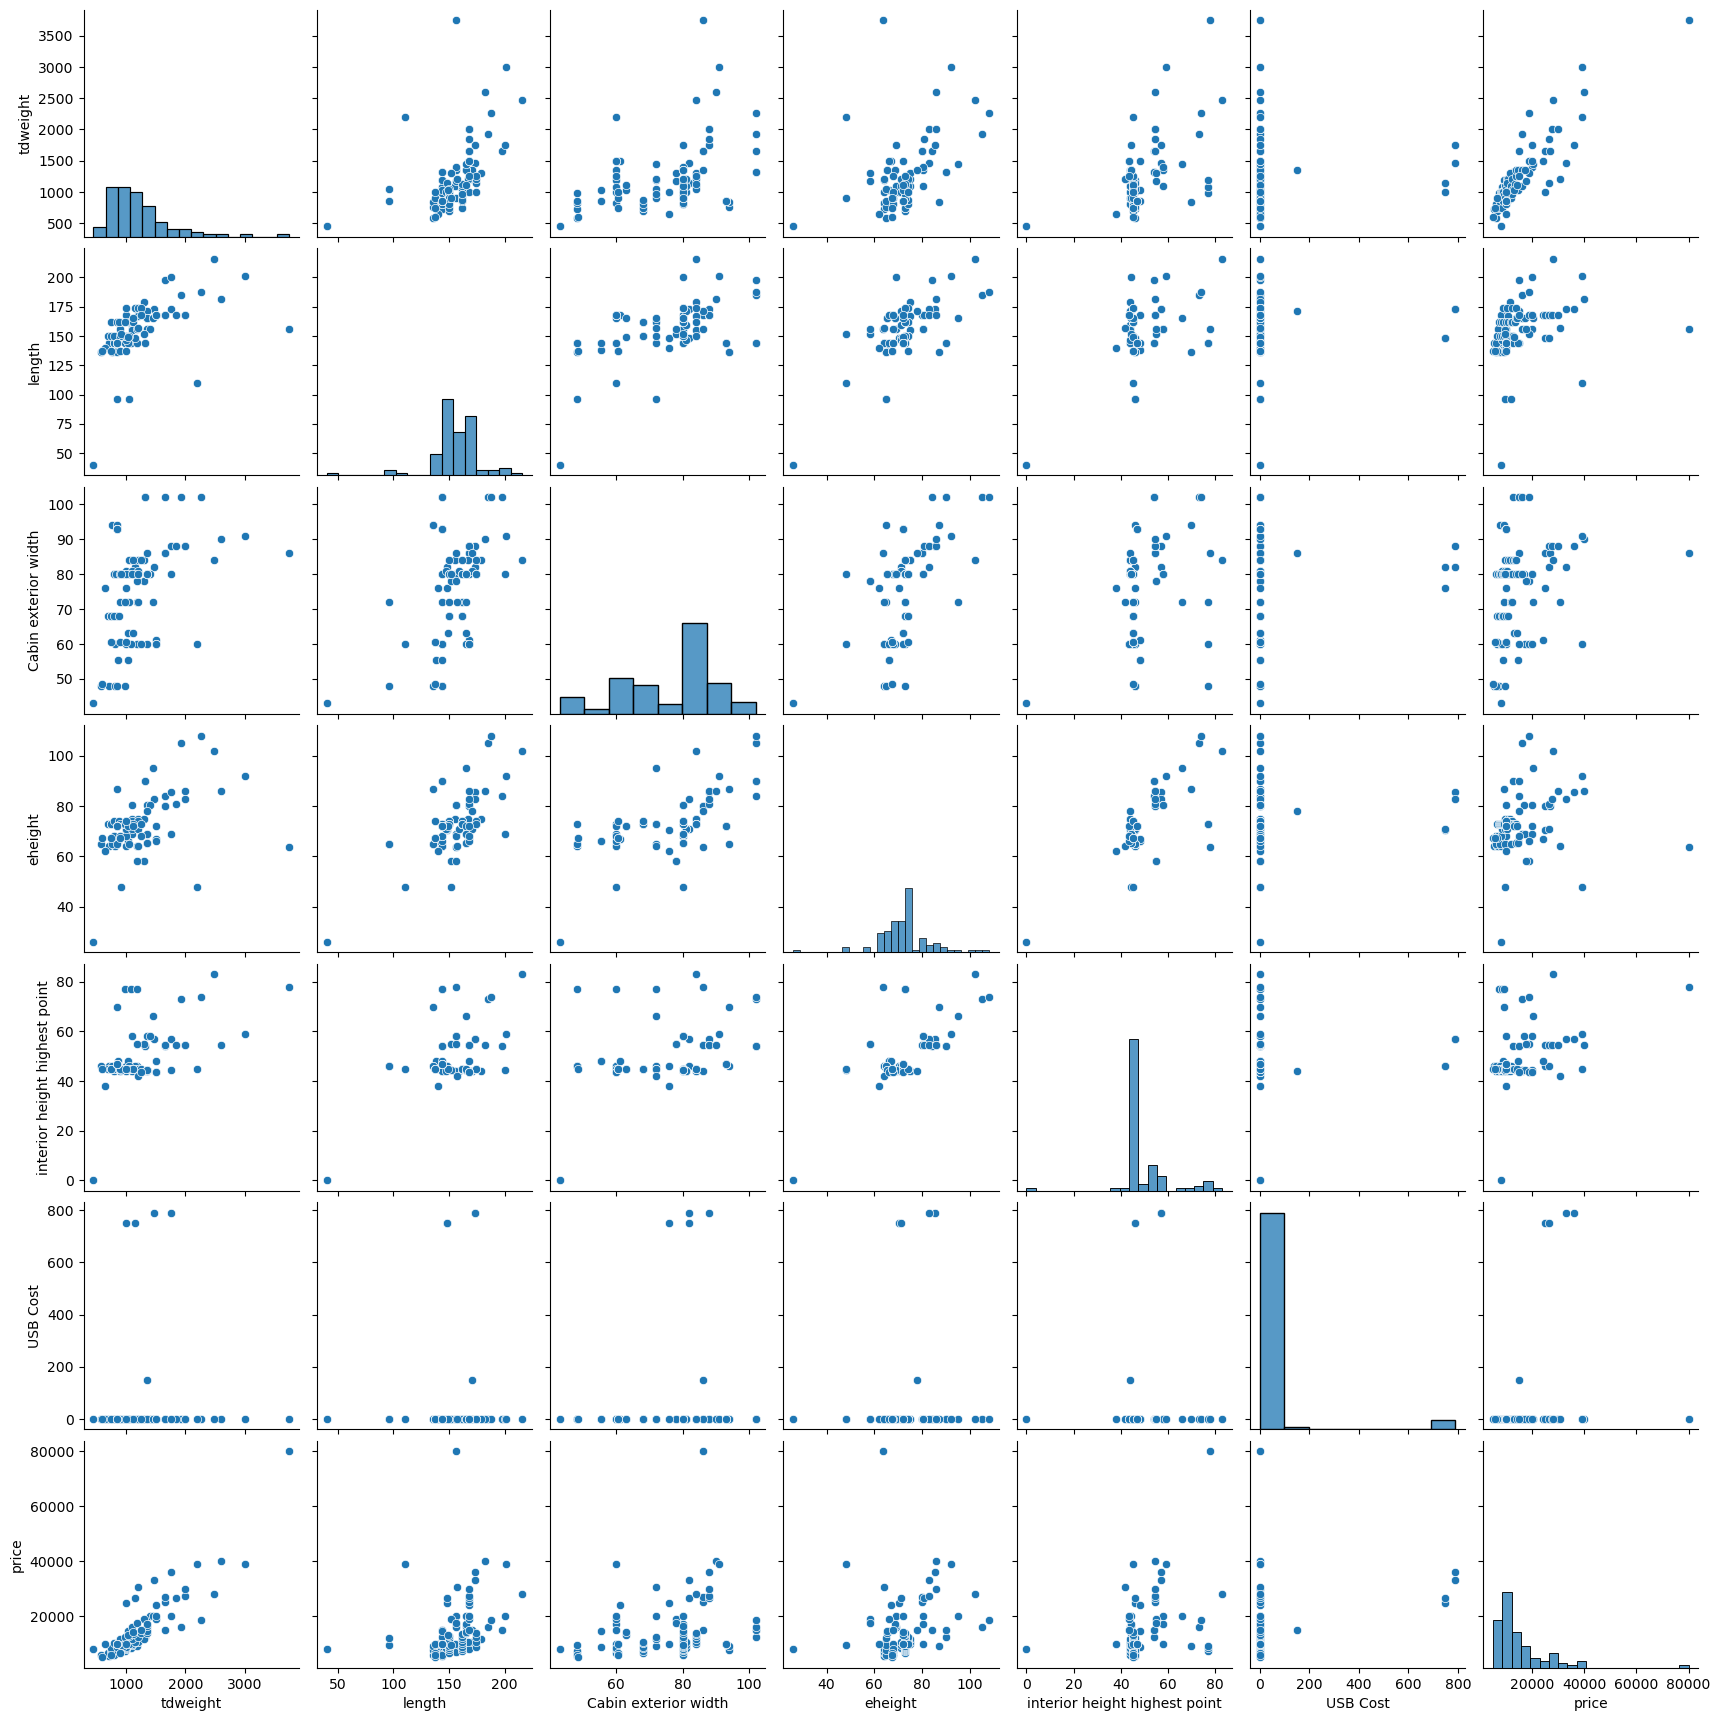

In [14]:
sns.pairplot(data)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

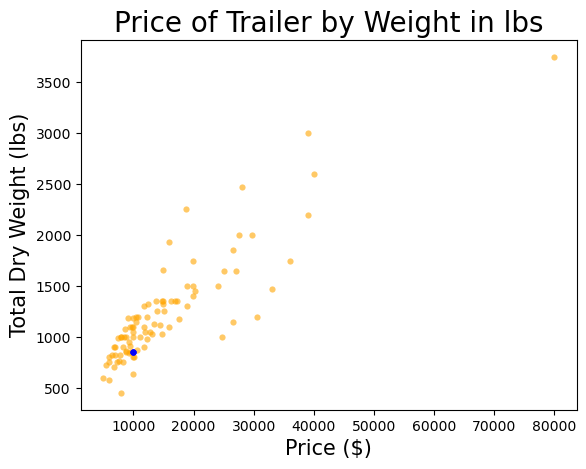

In [15]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

Now let's look at how a few features map onto the weight vs. price

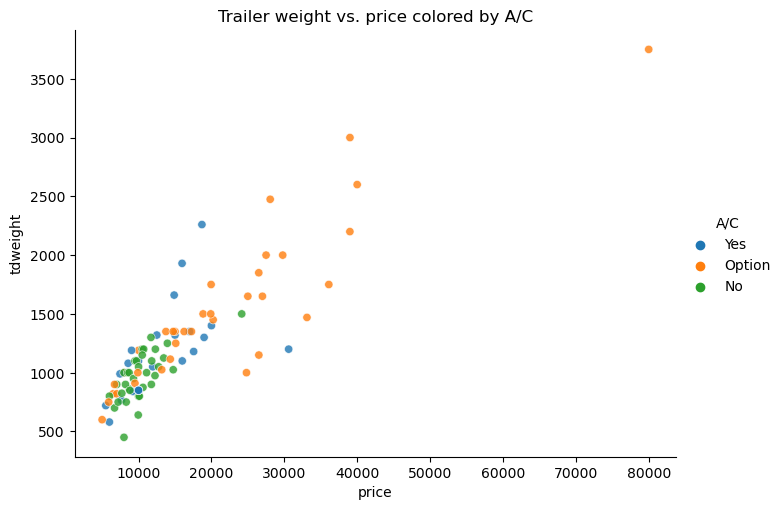

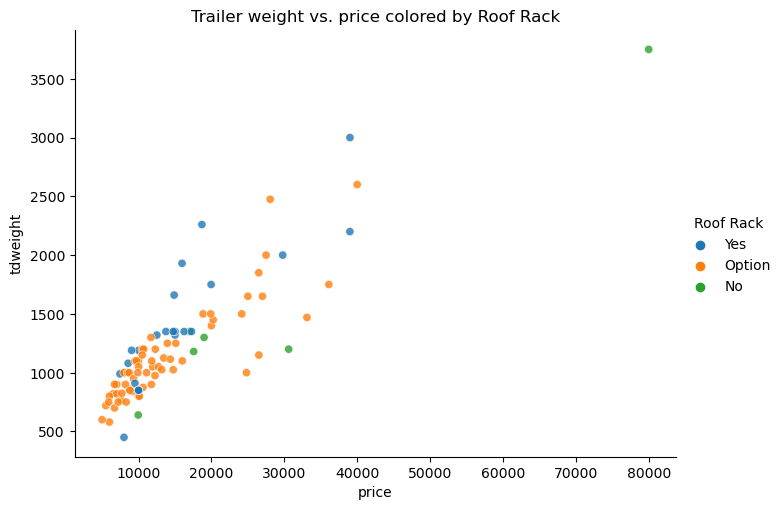

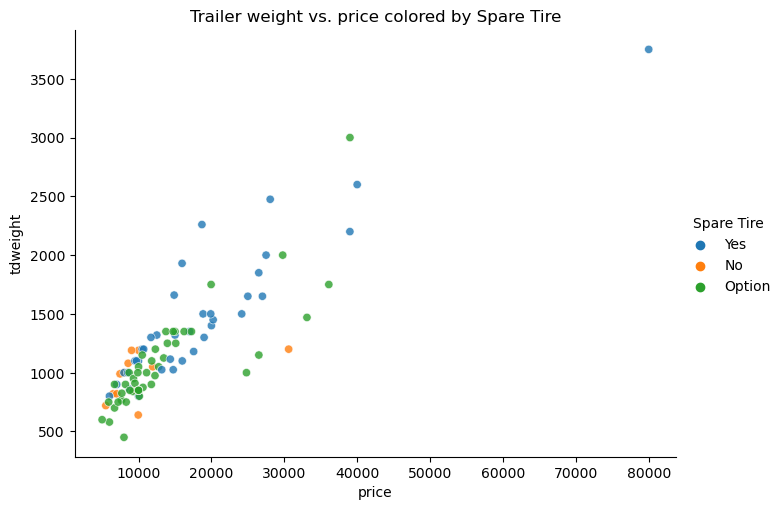

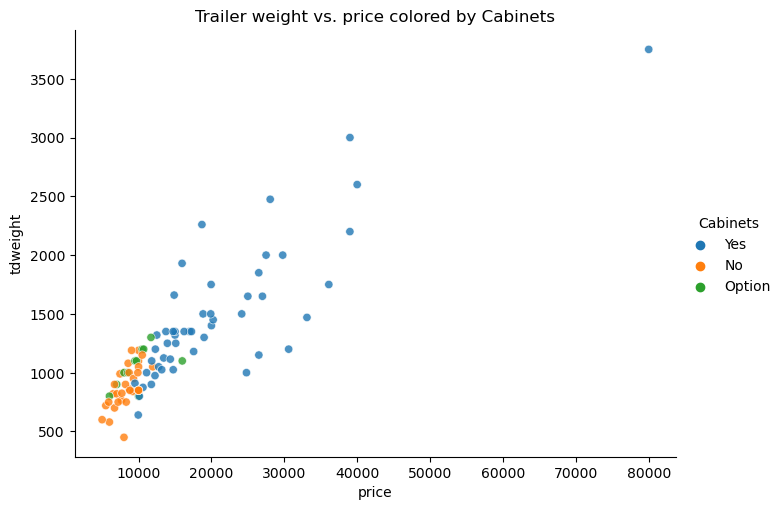

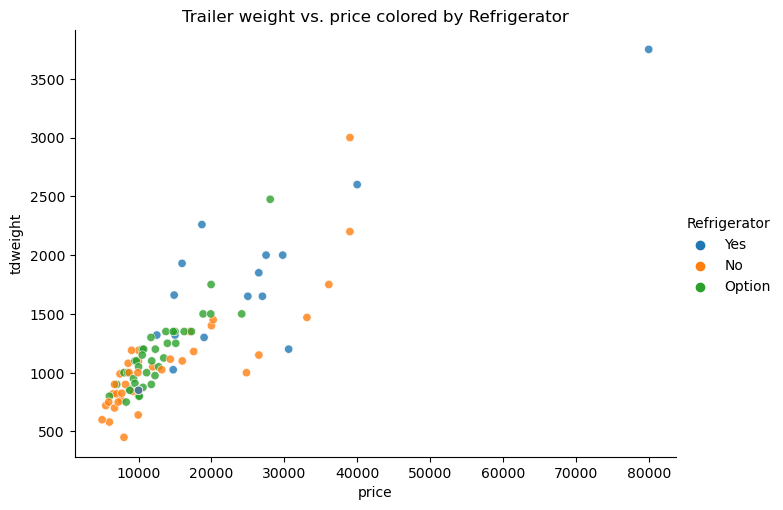

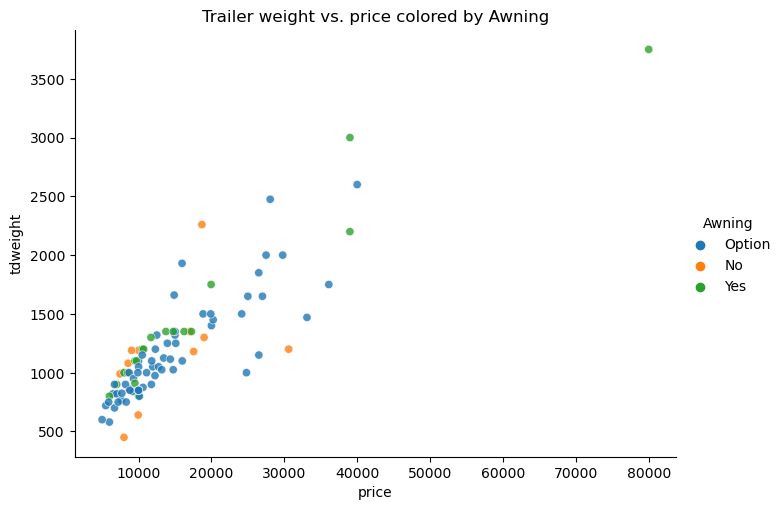

In [16]:
for c in ['A/C', 'Roof Rack', 'Spare Tire', 'Cabinets', 'Refrigerator', 'Awning']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.8)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [17]:
#select the categorical data for encoding
cat_data = data.iloc[:, 5:24]
cat_data

,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging
0,84.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
1,90.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
2,90.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
3,105.0,73.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
4,108.0,74.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,Yes,Yes,No,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,72.0,47.0,On Road/Off Road,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,No,No,No,Option,No,No,No
92,72.0,47.0,On Road/Off Road,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,No,No,No,Option,No,No,Yes
93,72.0,47.0,On Road/Off Road,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,No,No,No,Option,No,Yes,Yes
94,72.0,47.0,On Road/Off Road,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,No,No,No,Option,Yes,Yes,Yes


In [18]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,25,10,1,2,2,...,2,1,2,2,1,2,2,2,0,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,2,1,2,2,1,2,2,2,0,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,2,1,2,2,1,2,2,2,0,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,33,18,1,2,2,...,2,1,2,2,1,2,2,2,0,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,34,19,1,2,2,...,2,1,2,2,0,2,2,2,0,18689


In [19]:
#make a copy of the data for later
data2=data

In [20]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,Driver Side Window,Driver Side Door,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
tdweight,1.000000,0.521120,0.383462,0.376712,0.533994,-2.419251e-01,0.159684,0.067950,0.162559,0.067329,...,0.382148,0.554536,0.548321,0.436766,0.178002,0.332057,0.513358,0.268035,0.057849,0.876003
length,0.521120,1.000000,0.469431,0.545975,0.253209,-5.778539e-02,-0.103066,-0.006574,0.079900,0.231305,...,0.330261,0.373805,0.471059,0.392385,0.225914,0.227764,0.244650,0.443257,0.061225,0.299917
Cabin exterior width,0.383462,0.469431,1.000000,0.592086,0.249332,2.941188e-01,0.152444,0.182286,-0.031579,-0.198581,...,0.378452,0.056221,0.310798,0.424305,0.183494,0.391910,0.321489,0.409569,0.098633,0.258535
eheight,0.376712,0.545975,0.592086,1.000000,0.497092,-4.427820e-02,0.076161,0.217978,0.183749,-0.127168,...,0.331609,0.236931,0.246899,0.266025,-0.033124,0.350113,0.115871,0.463518,0.127800,0.163030
interior height highest point,0.533994,0.253209,0.249332,0.497092,1.000000,-1.254170e-02,0.498209,0.106421,0.352271,-0.109428,...,0.097885,0.240890,0.080885,0.061989,-0.322745,0.018037,0.221380,0.041205,0.082543,0.411303
Usage Intent- On or Off Road,-0.241925,-0.057785,0.294119,-0.044278,-0.012542,1.000000e+00,0.290159,0.055541,-0.125572,-0.338664,...,0.004043,-0.373408,-0.350725,0.010336,-0.147915,-0.063466,0.209351,-0.148366,-0.213880,-0.222513
A/C,0.159684,-0.103066,0.152444,0.076161,0.498209,2.901591e-01,1.000000,0.266335,0.103009,-0.452579,...,-0.111879,-0.008937,-0.065146,-0.116270,-0.363035,-0.053625,0.383133,-0.054205,0.025817,0.131705
Roof Rack,0.067950,-0.006574,0.182286,0.217978,0.106421,5.554068e-02,0.266335,1.000000,-0.228207,-0.167407,...,-0.145439,0.125259,-0.083640,0.030755,0.156248,0.046802,0.258656,0.283178,-0.061989,-0.141106
Driver Side Window,0.162559,0.079900,-0.031579,0.183749,0.352271,-1.255716e-01,0.103009,-0.228207,1.000000,-0.018344,...,-0.025209,0.080881,0.072920,0.194630,-0.363242,-0.012210,-0.097759,-0.001409,-0.282082,0.034511
Driver Side Door,0.067329,0.231305,-0.198581,-0.127168,-0.109428,-3.386641e-01,-0.452579,-0.167407,-0.018344,1.000000,...,-0.251618,0.194002,0.207380,0.081597,-0.022642,-0.165152,-0.129155,0.012131,0.151532,0.106616


<AxesSubplot:>

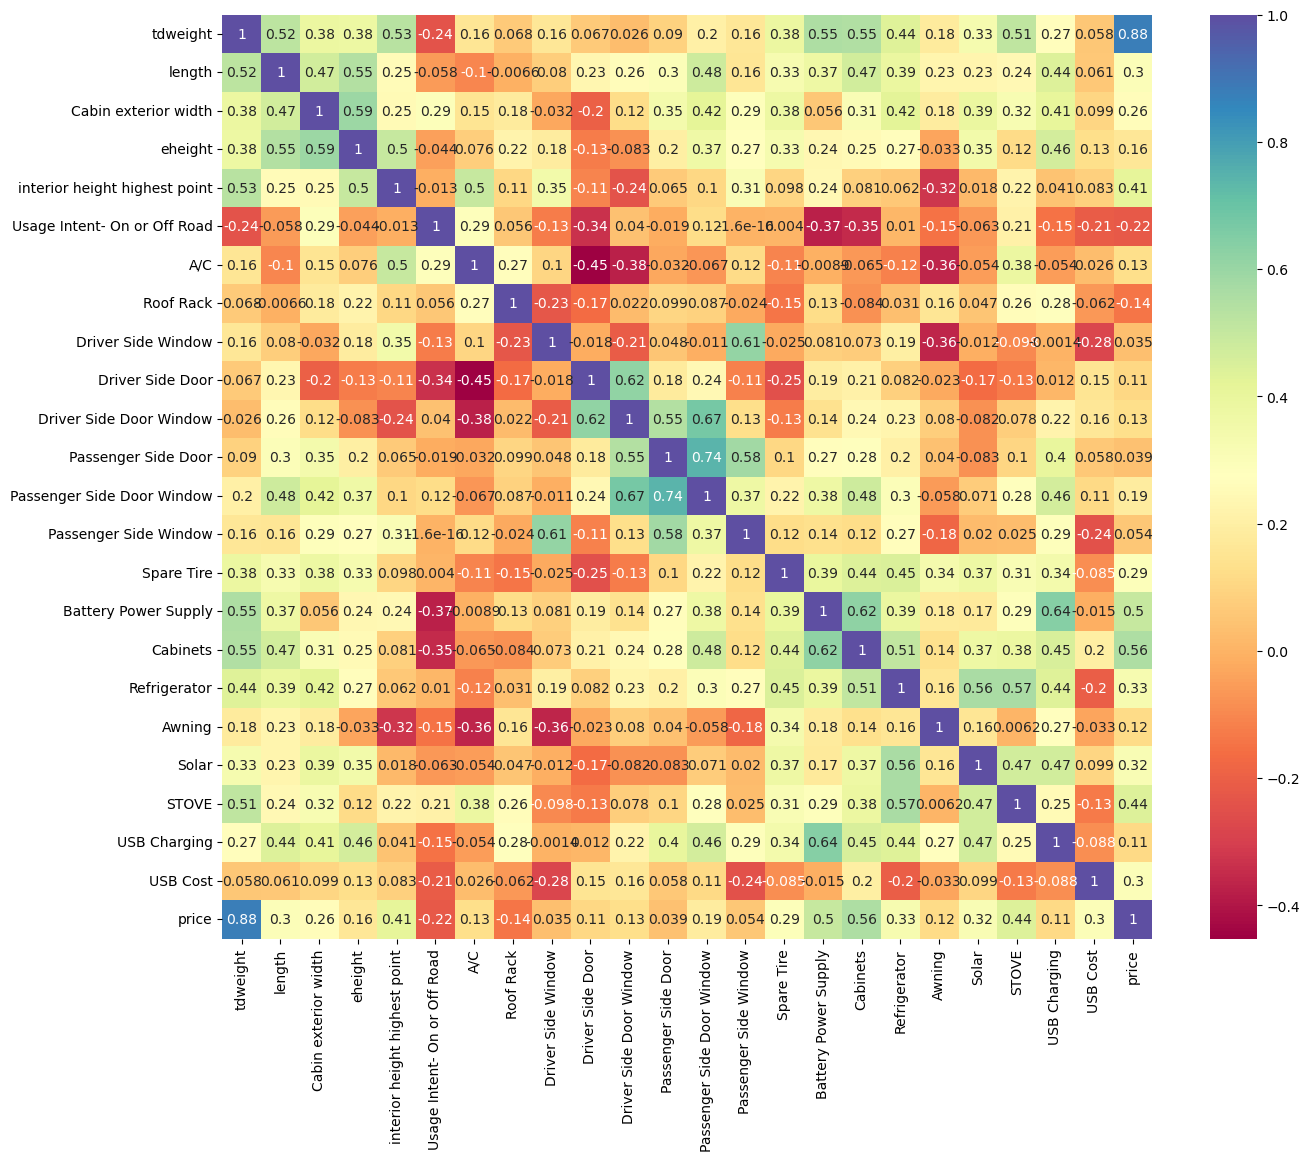

In [21]:
plt.figure(figsize=(15,12))
sns.heatmap(corr,annot=True,cmap="Spectral")

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

In [22]:
data2=data2.drop(data.index[91:])

In [23]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [25]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

R^2 :  0.8961133310351053
MAE : 2208.1479234596172
RMSE: 2513.522522423031


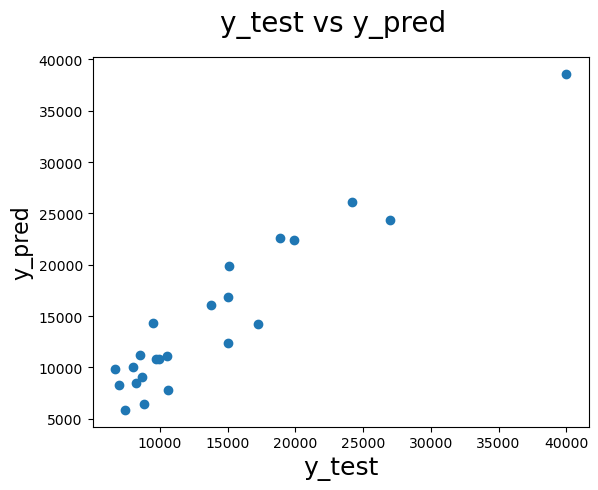

In [27]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.7696415104693978
MAE : 2487.7391304347825
RMSE: 3742.8720546381633


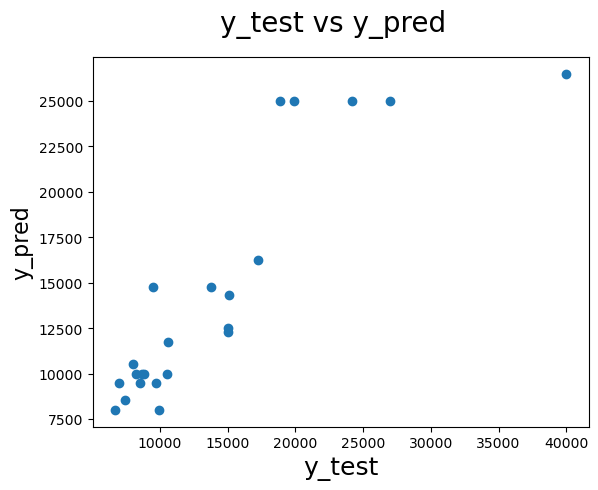

In [28]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.6128914173594399
MAE : 3941.3318809128327
RMSE: 4851.983000377989


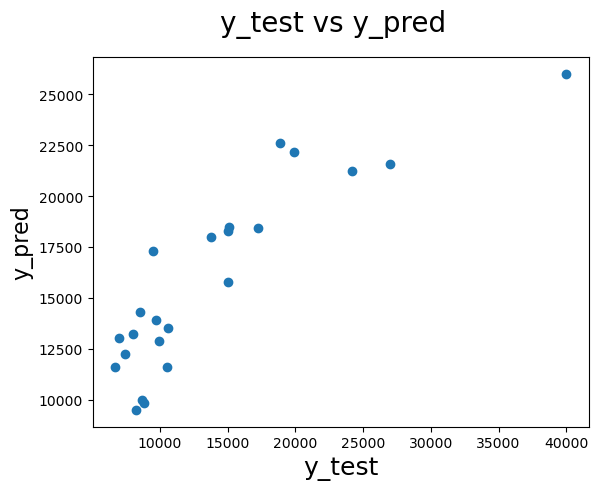

In [29]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.9028929585127342
MAE : 2086.7593854608717
RMSE: 2430.122866053717


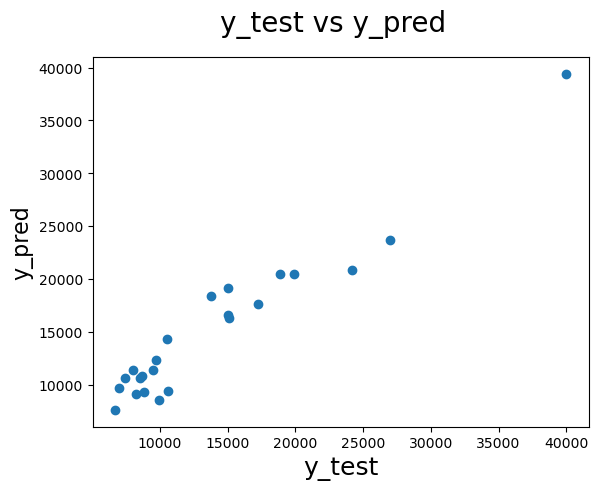

In [30]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.8969131237764673
MAE : 2165.984273691616
RMSE: 2503.8283950375844


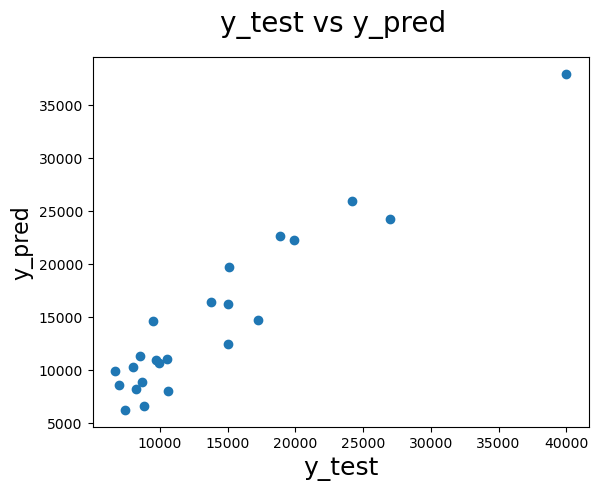

In [31]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


R^2 :  0.8967892852099479
MAE : 2200.5812341750584
RMSE: 2505.3318718347473


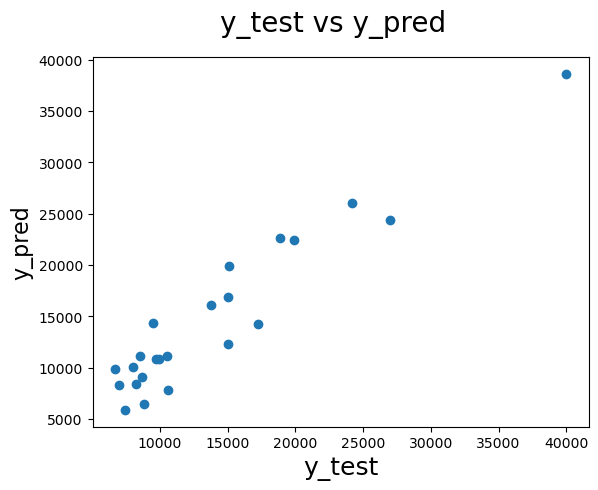

In [32]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.8964886050484293
MAE : 2166.2040924382213
RMSE: 2508.9785656295103


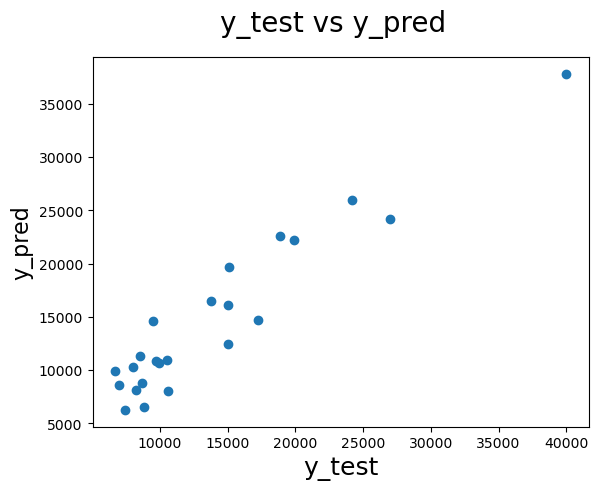

In [33]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.8986393333377731
MAE : 2133.756502018545
RMSE: 2482.7763489130157


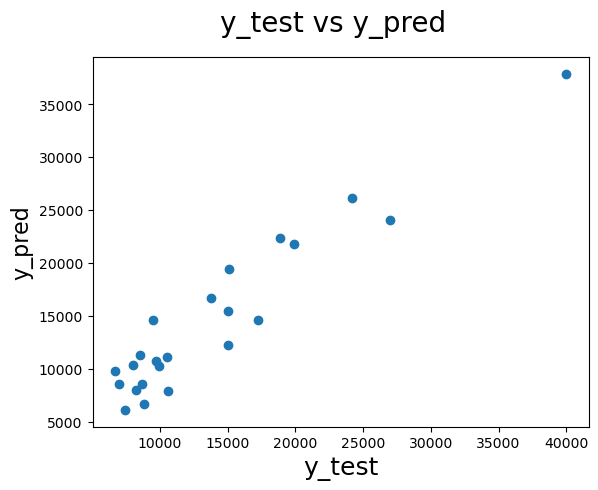

In [34]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.05210226046751232
MAE : 5594.036177021743
RMSE: 7998.929099260875


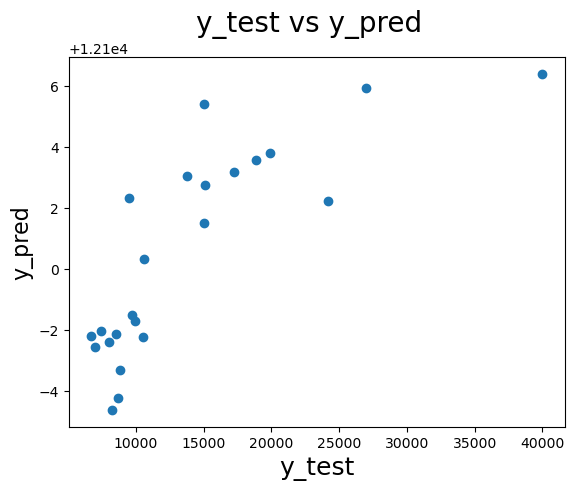

In [35]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.8086969805218651
MAE : 2550.254991284078
RMSE: 3410.8591275108465


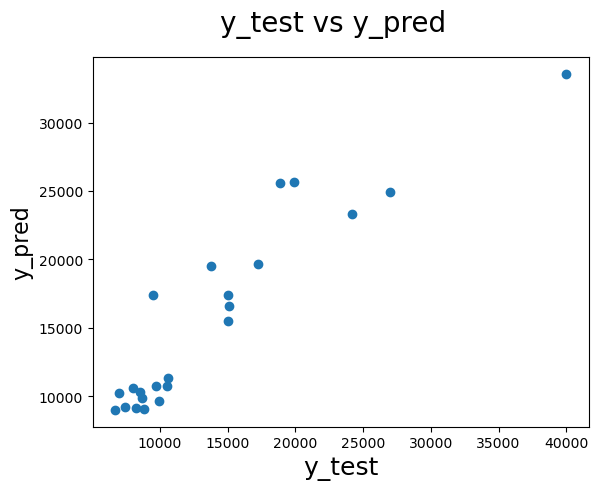

In [36]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance

The features which have been included thus far are based on features that have enough data available online to realistically include, and picking out which ones are actually important is still in progress. Currently, a more novel feature information (e.g. solar panels) are being mined, while others whihc are already included need to be optimized. One feature which is currently in process of engineering is the number of doors and if they include windows. the information is currently held in 4 seperate columns which have low correlation to the price, and should be combined into a single column containing all of the information to improve calculations. 

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(20,'Score'))  

                            Specs         Score
22                       USB Cost  64264.953560
0                        tdweight  20119.806455
3                         eheight    374.066810
1                          length    287.938202
4   interior height highest point    253.398224
2            Cabin exterior width    209.611473
20                          STOVE    111.500000
16                       Cabinets     60.752252
6                             A/C     60.681818
17                   Refrigerator     60.470588
8              Driver Side Window     50.847107
21                   USB Charging     49.382114
19                          Solar     46.906250
15           Battery Power Supply     46.311881
5    Usage Intent- On or Off Road     44.968085
9                Driver Side Door     37.590909
10        Driver Side Door Window     33.834158
14                     Spare Tire     27.952586
18                         Awning     23.712121
12     Passenger Side Door Window     21

[0.2038138  0.13243636 0.12195043 0.10067142 0.04084774 0.04557901
 0.02348649 0.02811954 0.02060774 0.02459295 0.02179044 0.01008309
 0.01885527 0.02245071 0.02538831 0.02215535 0.02149763 0.02228511
 0.02607165 0.02253382 0.02082293 0.01459362 0.00936656]


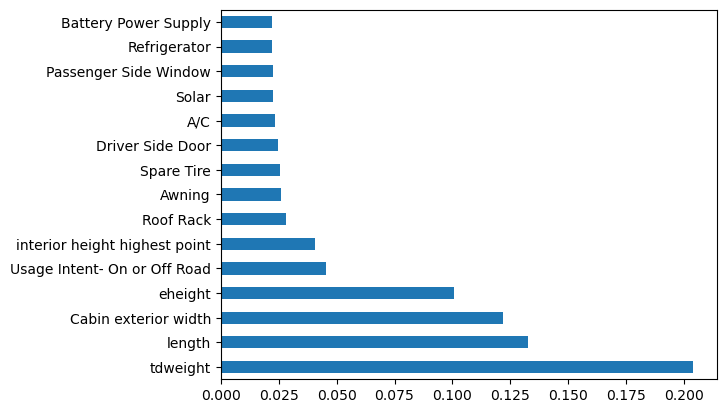

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

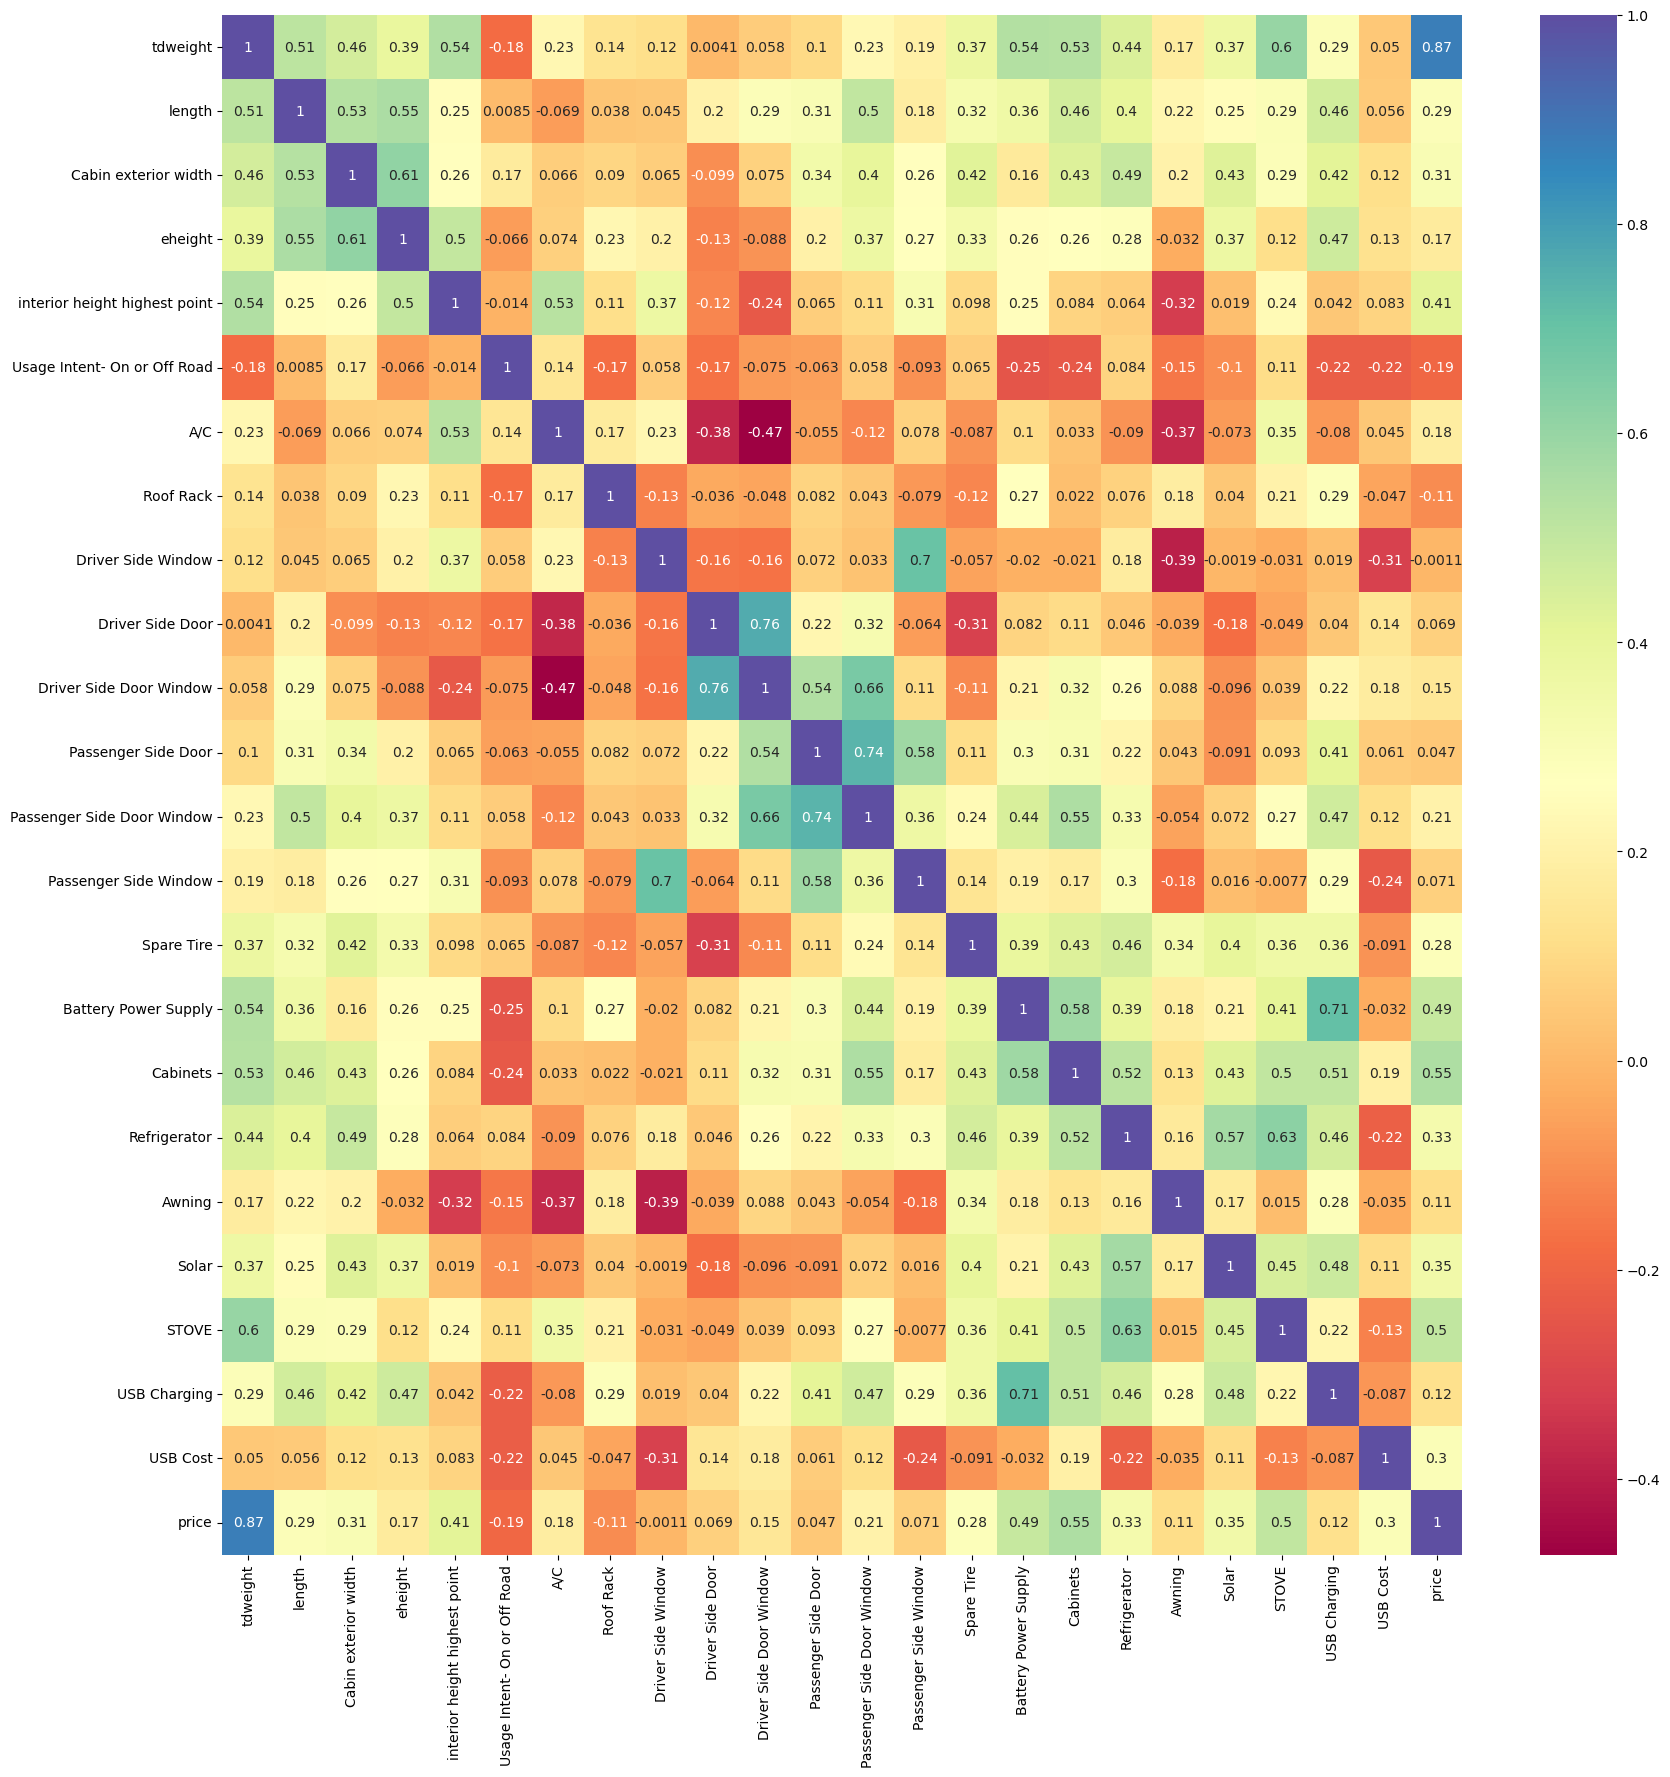

In [39]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="Spectral")

# Feature Engineering
This section is in progress while more feature data is collected.

In [40]:
#the last columns contain values we want to predict
data3=data.drop(data.index[91:])

In [41]:
data3

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,25,10,1,2,2,...,2,1,2,2,1,2,2,2,0,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,2,1,2,2,1,2,2,2,0,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,2,1,2,2,1,2,2,2,0,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,33,18,1,2,2,...,2,1,2,2,1,2,2,2,0,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,34,19,1,2,2,...,2,1,2,2,0,2,2,2,0,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Aero Teardrops,The Burnside,1250,168.0,60.0,11,3,0,1,1,...,1,2,2,1,1,1,1,2,0,15099
87,MyMiniTrailer,Carpe Diem Mini,600,137.0,48.5,10,6,1,1,1,...,1,0,0,0,1,1,0,0,0,4995
88,MyMiniTrailer,Gypsy,900,137.0,60.5,10,6,1,1,1,...,1,0,0,0,1,1,0,0,0,6700
89,MyMiniTrailer,Serenity X,750,137.0,60.5,10,6,1,1,1,...,1,0,0,0,1,1,0,0,0,5900


In [42]:
#removing everything with a negative correlation
X = data3.drop(['price', 'Roof Rack', 'Usage Intent- On or Off Road', 'USB Cost', 'Manufacturer', 'model'],axis=1)
y=data3['price']

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [44]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

R^2 :  0.7272070047220247
MAE : 3073.995136618569
RMSE: 4137.570557155188


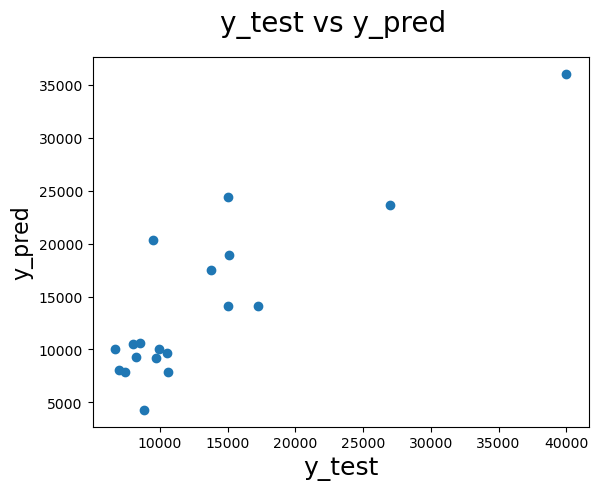

In [46]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.4654568947802553
MAE : 2899.2631578947367
RMSE: 5791.888220424729


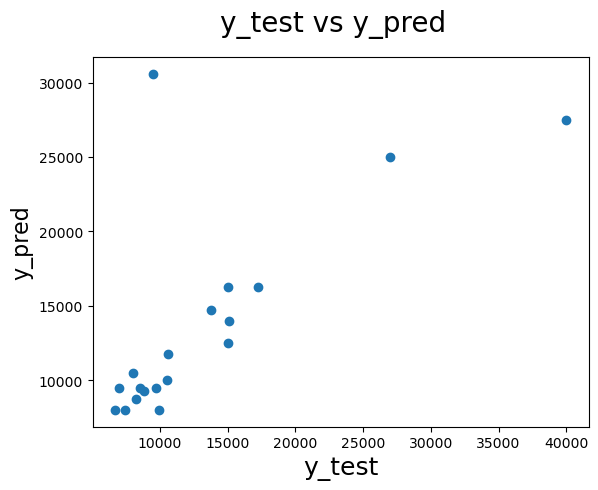

In [47]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5125902339448263
MAE : 4621.830821863694
RMSE: 5530.646731921386


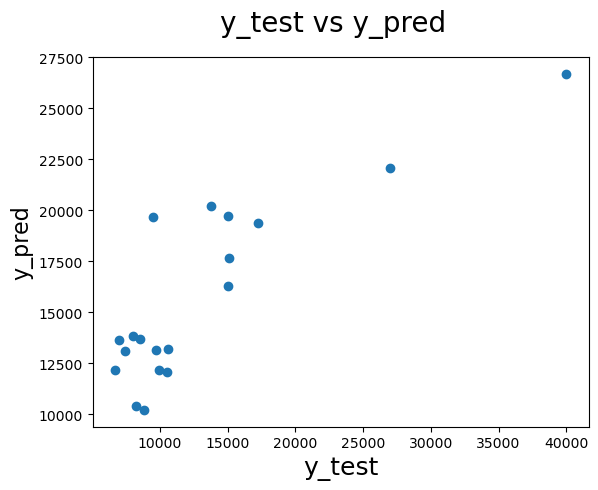

In [48]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.8883556574132437
MAE : 2304.345729632819
RMSE: 2646.9587049179354


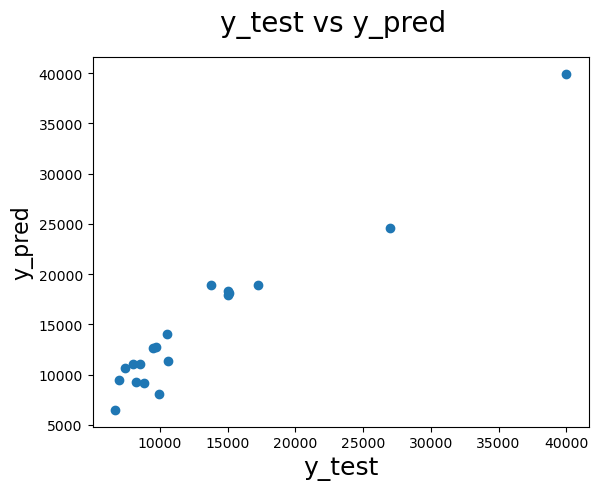

In [49]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7384602329369219
MAE : 3061.737668399101
RMSE: 4051.3304843133515


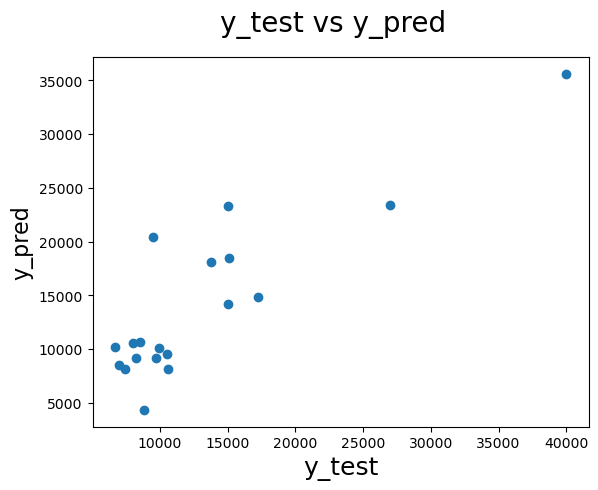

In [50]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7416167901508535
MAE : 3059.790106395049
RMSE: 4026.808253889915


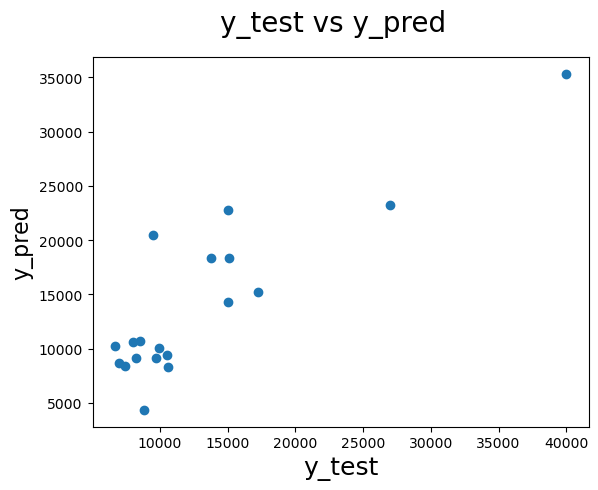

In [51]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.7445977366038361
MAE : 3057.8089863726527
RMSE: 4003.5123857415815


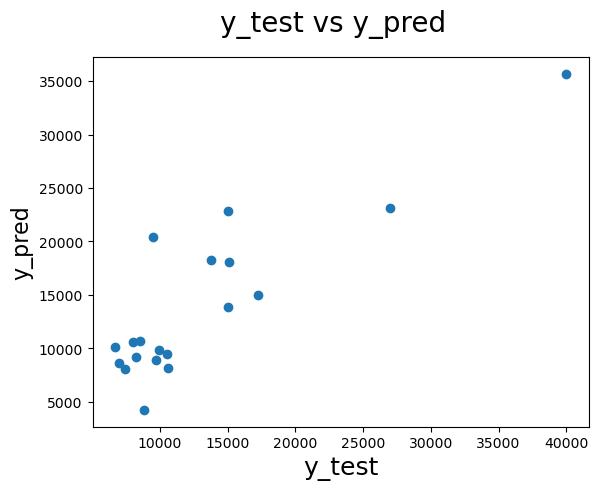

In [52]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.008780262336402833
MAE : 5239.24748852889
RMSE: 7956.592090746586


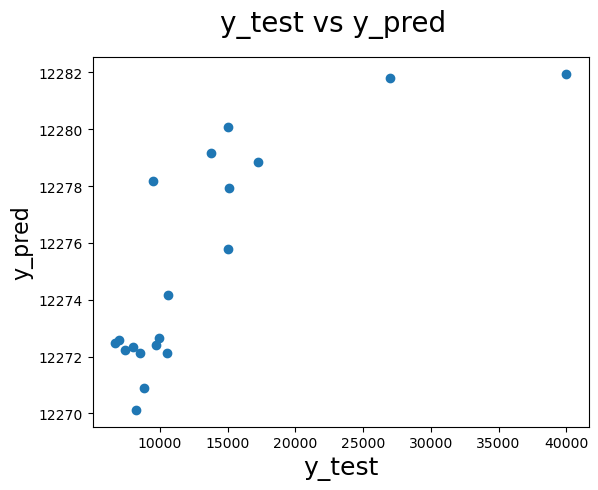

In [53]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.8602165826036112
MAE : 2254.057733907907
RMSE: 2961.8061630499833


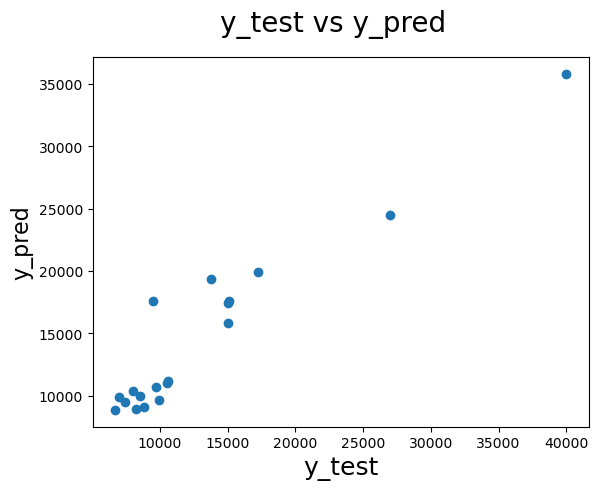

In [54]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.2088028  0.14510979 0.12552225 0.11813771 0.04245174 0.02806696
 0.02197046 0.02610786 0.02547911 0.00904223 0.01791099 0.02502978
 0.03005852 0.02617014 0.0315853  0.02130922 0.03480446 0.02596489
 0.01946327 0.01701253]


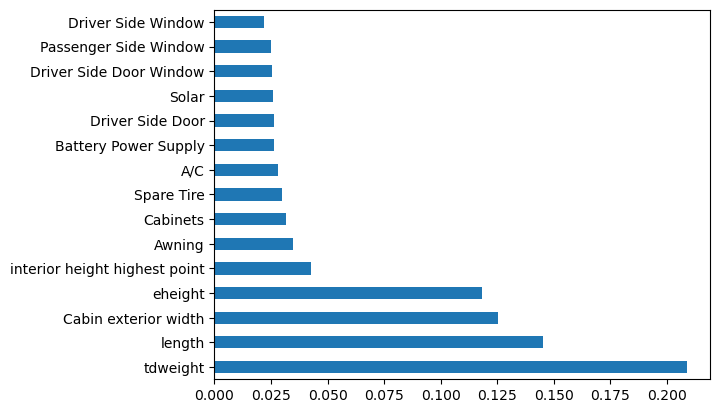

In [55]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [56]:
rfc=RandomForestRegressor(random_state=1)

In [57]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
     #'max_depth' : [5, 10, 15],
    # 'min_samples_leaf' : [1,2,3,5],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [58]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000, 5000]})

In [59]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_features': 'sqrt', 'n_estimators': 100}

R^2 :  0.7436231350310931
MAE : 2454.2514035087715
RMSE: 4011.143708594917


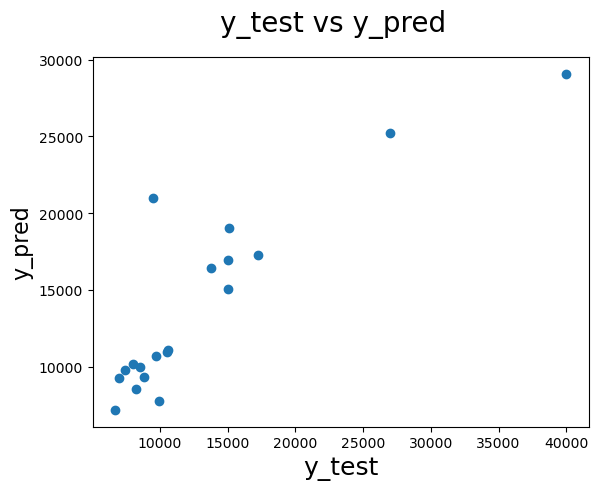

In [60]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=100, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

# Checking the value of interest

In [61]:
new_input = data.loc[91:]
new_input

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
91,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,1,0,0,0,1,0,0,0,0,9995
92,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,1,0,0,0,1,0,0,2,0,9995
93,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,1,0,0,0,1,0,2,2,0,9995
94,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,1,0,0,0,1,2,2,2,0,9995
95,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,1,0,0,2,1,2,2,2,0,9995


In [62]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Roof Rack', 'Usage Intent- On or Off Road', 'USB Cost', 'Manufacturer', 'model'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,interior height highest point,A/C,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging
91,850,144.0,93.0,16,8,2,0,0,3,2,3,2,1,0,0,0,1,0,0,0
92,850,144.0,93.0,16,8,2,0,0,3,2,3,2,1,0,0,0,1,0,0,2
93,850,144.0,93.0,16,8,2,0,0,3,2,3,2,1,0,0,0,1,0,2,2
94,850,144.0,93.0,16,8,2,0,0,3,2,3,2,1,0,0,0,1,2,2,2
95,850,144.0,93.0,16,8,2,0,0,3,2,3,2,1,0,0,2,1,2,2,2


In [63]:
new_input_scaled = scaler.fit_transform(new_input)

In [64]:
#CV?
new_output = final_model.predict(new_input_scaled)
new_output

array([13407.41, 13479.12, 14912.7 , 14665.33, 14835.25])

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>